In [16]:
import sqlite3
from rosidl_runtime_py.utilities import get_message
from rclpy.serialization import deserialize_message

import matplotlib.pyplot as plt
import numpy as np

In [17]:
class BagFileParser():
    def __init__(self, bag_file):
        self.conn = sqlite3.connect(bag_file)
        self.cursor = self.conn.cursor()

        ## create a message type map
        topics_data = self.cursor.execute("SELECT id, name, type FROM topics").fetchall()
        self.topic_type = {name_of:type_of for id_of,name_of,type_of in topics_data}
        self.topic_id = {name_of:id_of for id_of,name_of,type_of in topics_data}
        self.topic_msg_message = {name_of:get_message(type_of) for id_of,name_of,type_of in topics_data}

    def __del__(self):
        self.conn.close()

    # Return [(timestamp0, message0), (timestamp1, message1), ...]
    def get_messages(self, topic_name):

        topic_id = self.topic_id[topic_name]
        # Get from the db
        rows = self.cursor.execute("SELECT timestamp, data FROM messages WHERE topic_id = {}".format(topic_id)).fetchall()
        # Deserialise all and timestamp them
        return [ (timestamp,deserialize_message(data, self.topic_msg_message[topic_name])) for timestamp,data in rows]

In [18]:
bag_file = 'Recordings/verde/verde_0.db3'

parser = BagFileParser(bag_file)

trajectory = parser.get_messages("/object/pose")

In [19]:
trajectory[0]

(1715206767467483980,
 geometry_msgs.msg.Pose(position=geometry_msgs.msg.Point(x=0.024051561030586272, y=0.01428721139308842, z=0.15367454348958443), orientation=geometry_msgs.msg.Quaternion(x=-0.004703166529713734, y=0.0012471229759793818, z=0.5358465464317144, w=0.8443013701197465)))

In [20]:
path = [[w[1].position.x, w[1].position.y] for w in trajectory]

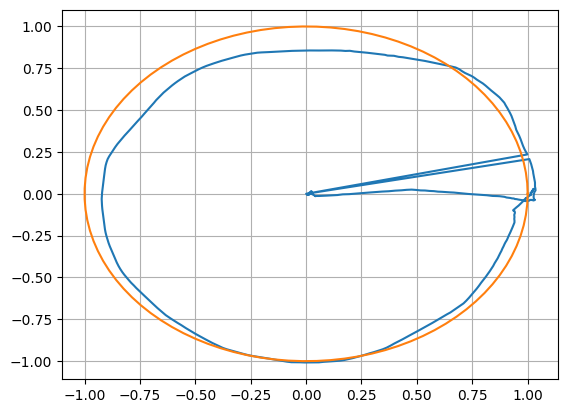

In [21]:
path = np.array(path)
points = np.linspace(0, 2*np.pi, 100)

plt.plot(path[:,0], path[:,1])
plt.plot(np.cos(points), np.sin(points))
plt.grid()

In [22]:
len(path)

1104